# Monografía Final
## Redes Neuronales - FIUBA
### Alumno: Julián Stejman

En este documento se utilizará una red neuronal entrenada con un algoritmo de aprendizaje por refuerzo PPO (Proximal Policy Optimization) que aprendiese a jugar niveles de Super Mario Bros para la NES. Para ello, se utilizará el entorno de OpenAI Gym, que simula el juego de Super Mario Bros, junto con una arquitectura Actor-Critic basada en capas convolucionales y frame stacking para capturar información temporal.

In [1]:
%pip install gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import torch
import torch.nn as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.8 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535718 sha256=7920c23f5ba270348406254dffd1395300845526054643e55e9371c49381de58
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Si se eliminara en la siguiente celda la línea que dice %%skip, se podría ver una simulación simple de como funciona el emulador del juego con el entorno. 

In [3]:

%%skip
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

La idea sería armar una red neuronal convolucional para poder interpretar de las imágenes recibidas una posible acción para que tomara el personaje del juego. Esta red luego utilizará un algoritmo de aprendizaje por refuerzo para poder mejorar su desempeño.

La arquitectura utiliza una red Actor-Critic con capas convolucionales que procesan 4 frames apilados del juego. Al recibir múltiples frames consecutivos, la CNN puede inferir velocidad y dirección del movimiento sin necesidad de una capa recurrente. El Actor predice la distribución de probabilidades sobre acciones (policy), mientras que el Critic estima el valor esperado del estado para el cálculo del advantage. Esta es la misma arquitectura que utiliza internamente Stable Baselines3 con `CnnPolicy`, y la que DeepMind usó originalmente para Atari.

In [4]:
class PPOActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions, hidden_size=512):
        super().__init__()
        
        # Capas convolucionales para procesamiento de imágenes
        # Arquitectura estándar Nature DQN (Mnih et al., 2015)
        self.image_processing = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calcular tamaño de salida de las conv
        flatten_size = self._get_flatten_size(input_shape)
        
        # Feature extractor compartido
        self.shared_fc = nn.Sequential(
            nn.Linear(flatten_size, hidden_size),
            nn.ReLU()
        )
        
        # Actor: predice distribución sobre acciones
        self.actor = nn.Linear(hidden_size, num_actions)
        
        # Critic: estima valor del estado
        self.critic = nn.Linear(hidden_size, 1)
        
        # Inicialización ortogonal (mejora estabilidad del entrenamiento)
        self._init_weights()
        
    def _get_flatten_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.image_processing(dummy_input)
            return output.shape[1]
    
    def _init_weights(self):
        """Inicialización ortogonal estándar para PPO"""
        for module in self.image_processing:
            if isinstance(module, nn.Conv2d):
                nn.init.orthogonal_(module.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(module.bias)
        nn.init.orthogonal_(self.shared_fc[0].weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.shared_fc[0].bias)
        nn.init.orthogonal_(self.actor.weight, gain=0.01)  # Pequeño para política inicial uniforme
        nn.init.zeros_(self.actor.bias)
        nn.init.orthogonal_(self.critic.weight, gain=1.0)
        nn.init.zeros_(self.critic.bias)
    
    def forward(self, x):
        """
        x: (batch_size, channels, height, width) — channels = 4 frames apilados
        """
        features = self.image_processing(x)
        features = self.shared_fc(features)
        
        action_logits = self.actor(features)
        value = self.critic(features)
        
        return action_logits, value

In [5]:
frame_stack_count = 4
dimensions = 84
input_shape = (frame_stack_count, dimensions, dimensions)
num_actions = len(RIGHT_ONLY)

test_model = PPOActorCritic(input_shape, num_actions)
dummy_state = torch.zeros(1, *input_shape)  # (batch_size, channels, height, width)
action_logits, value = test_model(dummy_state)
print(f"Action logits shape: {action_logits.shape}")
print(f"Value shape: {value.shape}")
print(f"Number of actions: {num_actions}")
print(f"Total parameters: {sum(p.numel() for p in test_model.parameters()):,}")

Action logits shape: torch.Size([1, 5])
Value shape: torch.Size([1, 1])
Number of actions: 5
Total parameters: 1,687,206


Para enviar a la red, se toman las siguientes decisiones de preprocesamiento estándar en RL:

1. **Frame skip (4)**: Repetir cada acción durante 4 frames consecutivos. Esto reduce la cantidad de decisiones que debe tomar el agente y hace el entrenamiento ~4x más rápido.
2. **Escala de grises**: Convertir de RGB a blanco y negro (reduce de 3 canales a 1).
3. **Resolución 84×84**: Tamaño estándar para RL en juegos, suficiente para capturar la información visual relevante.
4. **Frame stacking (4)**: Apilar los últimos 4 frames como canales, resultando en un tensor `(4, 84, 84)`. Esto permite que la CNN pueda inferir velocidad y dirección del movimiento.

Todo esto se implementa como wrappers del entorno, siguiendo la convención de OpenAI Gym.

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


State shape: (4, 84, 84)  ← debe ser (4, 84, 84)
Action space: 5 acciones: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]


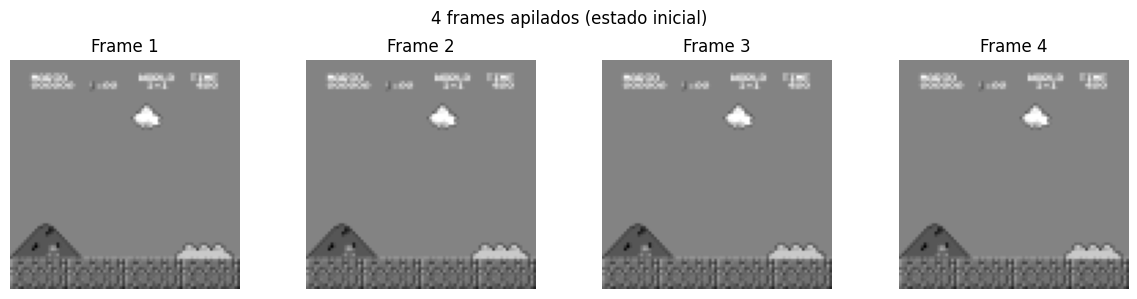

In [6]:
import gym
import numpy as np
from gym import Wrapper, ObservationWrapper
from gym.wrappers import GrayScaleObservation, FrameStack, ResizeObservation
from gym import spaces

class SkipFrame(Wrapper):
    """
    Repite la misma acción durante `skip` frames y acumula la recompensa.
    
    Esto es estándar en RL para Atari/Mario porque:
    - Frames consecutivos son casi idénticos, no tiene sentido decidir cada uno
    - Reduce 4x la cantidad de decisiones → entrenamiento más rápido
    - Reduce ruido en la señal de reward
    """
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip
    
    def step(self, action):
        total_reward = 0.0
        for _ in range(self._skip):
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return state, total_reward, done, info

class SqueezeObservation(ObservationWrapper):
    """
    Elimina la dimensión de canal trailing si es 1: (84,84,1) → (84,84).
    
    Necesario porque algunas versiones de gym producen (H,W,1) después de
    GrayScaleObservation + ResizeObservation, y FrameStack lo apilaría como
    (4,84,84,1) en vez de (4,84,84).
    """
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        if len(obs.shape) == 3 and obs.shape[-1] == 1:
            self.observation_space = spaces.Box(
                low=obs.low.squeeze(-1), high=obs.high.squeeze(-1), dtype=obs.dtype
            )

    def observation(self, obs):
        if obs.ndim == 3 and obs.shape[-1] == 1:
            return obs.squeeze(-1)
        return obs

def make_mario_env(world=1, stage=1):
    """Crea el entorno de Mario con todos los wrappers estándar de RL."""
    env = gym_super_mario_bros.make(f'SuperMarioBros-{world}-{stage}-v0')
    env = JoypadSpace(env, RIGHT_ONLY)
    env = SkipFrame(env, skip=4)
    env = ResizeObservation(env, shape=(dimensions, dimensions))    # (84, 84, 3)
    env = GrayScaleObservation(env, keep_dim=False)                 # (84, 84) idealmente
    env = SqueezeObservation(env)                                   # (84, 84) garantizado
    env = FrameStack(env, num_stack=frame_stack_count)              # (4, 84, 84)
    return env

# Crear entorno y verificar
env = make_mario_env()
state = env.reset()
state_np = np.array(state)
print(f"State shape: {state_np.shape}  ← debe ser (4, 84, 84)")
print(f"Action space: {env.action_space.n} acciones: {RIGHT_ONLY}")
assert state_np.shape == (4, 84, 84), f"Shape incorrecto: {state_np.shape}"

# Visualizar los 4 frames apilados
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(state_np[i], cmap='gray')
    axes[i].set_title(f'Frame {i+1}')
    axes[i].axis('off')
plt.suptitle('4 frames apilados (estado inicial)')
plt.tight_layout()
plt.show()

Para el entrenamiento con PPO, se utiliza un rollout buffer que acumula experiencias de un episodio completo o de N pasos de interacción. A diferencia de DQN (off-policy), PPO es on-policy: utiliza las experiencias para actualizar la red y luego las descarta, enfocándose en lo más reciente.

In [7]:
from collections import deque

class RolloutBuffer:
    """
    Buffer on-policy para PPO: almacena experiencias de interacción con el entorno.
    
    A diferencia de DQN (off-policy), PPO es on-policy: recolecta experiencias, 
    las usa para actualizar la red, y luego las descarta.
    
    El buffer almacena:
    - states: observaciones del entorno (4 frames apilados)
    - actions: acciones tomadas
    - rewards: recompensas recibidas
    - values: estimaciones V(s) del critic
    - log_probs: log-probabilidades de las acciones bajo la política actual
    - dones: flags de fin de episodio
    """
    def __init__(self):
        self.clear()
    
    def push(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)
    
    def compute_returns_and_advantages(self, last_value=0, gamma=0.99, gae_lambda=0.95):
        """
        Calcula returns y advantages usando Generalized Advantage Estimation (GAE).
        
        GAE balancea entre TD (bajo bias, alta varianza) y Monte Carlo (alto bias, baja varianza).
        Con λ=0.95 se obtiene un buen compromiso.
        
        Fórmulas:
        - δ_t = r_t + γ * V(s_{t+1}) - V(s_t)
        - A_t = Σ_{l=0}^{∞} (γλ)^l * δ_{t+l}
        - R_t = A_t + V(s_t)
        """
        returns = []
        advantages = []
        gae = 0
        
        # Iterar hacia atrás
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = last_value
            else:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = self.values[t + 1]
            
            delta = self.rewards[t] + gamma * next_value * next_non_terminal - self.values[t]
            gae = delta + gamma * gae_lambda * next_non_terminal * gae
            
            returns.insert(0, gae + self.values[t])
            advantages.insert(0, gae)
        
        return torch.tensor(returns, dtype=torch.float32), torch.tensor(advantages, dtype=torch.float32)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
    
    def __len__(self):
        return len(self.states)

## Función de Entrenamiento PPO

### Flujo del entrenamiento:
```
Para cada episodio:
  1. Recolectar experiencias (rollout)
     - Forward pass: observación → CNN → Actor & Critic
     - Sample acción de la distribución del Actor
     - Guardar (state, action, reward, log_prob, value, done)
  2. Si no terminó, bootstrap V(s_final) para GAE
  3. Calcular returns y advantages con GAE (λ=0.95)
  4. Normalizar advantages
  5. Para cada época (4 típicamente):
     - Barajar datos en mini-batches
     - Calcular PPO clipped loss + value loss - entropía
     - Actualizar modelo con gradient clipping
  6. Guardar checkpoint cada 25 episodios
```

### Detalles clave:
- **Sin LSTM**: La CNN procesa los 4 frames apilados directamente. Esto es más simple y estable que usar LSTM, ya que los 4 frames ya contienen información temporal suficiente.
- **Frame skip**: El wrapper `SkipFrame` repite cada acción 4 veces, reduciendo la cantidad de decisiones y acelerando el entrenamiento.
- **Reward shaping conservador**: Normalizamos el reward del entorno y agregamos un bonus suave por avanzar. No usamos bonuses grandes que desestabilicen el entrenamiento.
- **Bootstrap**: Si el episodio no terminó naturalmente (truncado por `max_steps`), estimamos el valor futuro con el Critic para no perder información.

## Preprocesamiento con Wrappers de Gym

El pipeline de preprocesamiento se implementa como una cadena de wrappers, donde cada uno transforma la observación del entorno:

```
SuperMarioBros-v0  →  JoypadSpace  →  SkipFrame  →  GrayScale  →  Resize  →  FrameStack
     (240,256,3)      (reduce acciones)  (repite 4)   (H,W,1→H,W)  (84,84)    (4,84,84)
```

### ¿Por qué estos wrappers?

| Wrapper | Qué hace | Por qué |
|---------|----------|---------|
| `JoypadSpace` | Reduce 256 acciones → 5 (RIGHT_ONLY) | Espacio de acciones más pequeño = más fácil de aprender |
| `SkipFrame(4)` | Repite acción 4 frames, acumula reward | 4x más rápido, frames consecutivos son casi iguales |
| `GrayScale` | RGB → escala de grises | 3x menos datos, el color no aporta información útil |
| `Resize(84,84)` | Redimensiona a 84×84 | Tamaño estándar, reduce cómputo en CNN |
| `FrameStack(4)` | Apila últimos 4 frames como canales | Permite inferir velocidad y dirección |

**Nota**: Todo el preprocesamiento ocurre en los wrappers del entorno, no manualmente en el loop de entrenamiento. Esto es más limpio y menos propenso a errores.

In [8]:
def diagnostico_training(rewards, window=10):
    """
    Análisis detallado del entrenamiento para detectar problemas
    """
    print(f"\n{'='*70}")
    print(f"🔍 DIAGNÓSTICO DEL ENTRENAMIENTO")
    print(f"{'='*70}\n")
    
    # 1. Estadísticas básicas
    print(f"📊 Estadísticas Generales:")
    print(f"   Total episodios: {len(rewards)}")
    print(f"   Reward promedio: {np.mean(rewards):.2f}")
    print(f"   Reward std: {np.std(rewards):.2f}")
    print(f"   Reward máximo: {max(rewards):.2f}")
    print(f"   Reward mínimo: {min(rewards):.2f}\n")
    
    # 2. Tendencia
    if len(rewards) >= 20:
        first_half = rewards[:len(rewards)//2]
        second_half = rewards[len(rewards)//2:]
        improvement = np.mean(second_half) - np.mean(first_half)
        
        print(f"📈 Tendencia:")
        print(f"   Primera mitad avg: {np.mean(first_half):.2f}")
        print(f"   Segunda mitad avg: {np.mean(second_half):.2f}")
        print(f"   Mejora: {improvement:+.2f} ", end="")
        
        if improvement > 50:
            print("✅ (Buena progresión)")
        elif improvement > 0:
            print("⚠️  (Mejora lenta)")
        else:
            print("❌ (Sin mejora o empeorando)")
        print()
    
    # 3. Últimos episodios
    if len(rewards) >= window:
        recent = rewards[-window:]
        print(f"🎯 Últimos {window} episodios:")
        print(f"   Promedio: {np.mean(recent):.2f}")
        print(f"   Mejor: {max(recent):.2f}")
        print(f"   Peor: {min(recent):.2f}")
        print(f"   Std: {np.std(recent):.2f} ", end="")
        
        if np.std(recent) > 200:
            print("⚠️  (Alta varianza - exploración activa)")
        elif np.std(recent) < 10:
            print("❌ (Muy baja varianza - colapsó a política fija)")
        else:
            print("✅ (Varianza saludable)")
        print()
    
    # 4. Estancamiento
    if len(rewards) >= 30:
        last_30 = rewards[-30:]
        moving_avg = np.convolve(last_30, np.ones(10)/10, mode='valid')
        
        if len(moving_avg) > 1:
            trend = np.polyfit(range(len(moving_avg)), moving_avg, 1)[0]
            print(f"📉 Análisis de estancamiento (últimos 30):")
            print(f"   Pendiente del promedio móvil: {trend:.3f}")
            
            if abs(trend) < 0.5:
                print("   ❌ ESTANCADO - Considerar:")
                print("      • Aumentar entropy_coef_start a 0.1")
                print("      • Reducir clip_ratio a 0.1")
                print("      • Modificar reward shaping")
                print("      • Reiniciar entrenamiento desde cero")
            elif trend > 0:
                print("   ✅ Mejorando gradualmente - seguir entrenando")
            else:
                print("   ⚠️  Decayendo - posible overfitting")
    
    print(f"\n{'='*70}")

# Ejemplo de uso (descomentar después de entrenar):
# diagnostico_training(improved_rewards)

print("✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)")

✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)


In [9]:
def train_ppo(env, model, num_episodes=500, num_epochs=4,
              batch_size=64, gamma=0.99, gae_lambda=0.95, learning_rate=2.5e-4,
              clip_ratio=0.2, entropy_coef=0.01, value_coef=0.5,
              device="cpu", checkpoint_freq=25, checkpoint_path="mario_ppo.pt",
              max_steps_per_episode=2000):
    """
    Entrenamiento PPO estándar (sin LSTM).
    
    Mejoras sobre la versión anterior:
    - Sin LSTM → entrenamiento más simple y estable
    - Frame skip via wrappers → 4x menos decisiones por episodio
    - Normalización de observaciones → entrenamiento más rápido
    - Reward shaping conservador → señal más estable
    """
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-5)
    
    total_rewards = []  # Reward del entorno (sin shaping)
    best_reward = -float('inf')
    global_step = 0
    
    for episode in range(num_episodes):
        # ========== RECOLECCIÓN DE EXPERIENCIAS ==========
        state = env.reset()
        buffer = RolloutBuffer()
        
        episode_reward = 0       # Reward real del entorno
        episode_shaped = 0       # Reward con shaping (para el agente)
        episode_length = 0
        done = False
        prev_x_pos = 40
        max_x_pos = 40
        
        while not done and episode_length < max_steps_per_episode:
            # Convertir estado a tensor: (1, 4, 84, 84)
            state_np = np.array(state, dtype=np.float32).copy()
            state_tensor = torch.tensor(state_np / 255.0, dtype=torch.float32).unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_logits, value = model(state_tensor)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            
            # Ejecutar acción (SkipFrame ya repite 4 veces)
            next_state, reward, done, info = env.step(action.item())
            
            # ========== REWARD SHAPING CONSERVADOR ==========
            shaped_reward = reward / 15.0  # Normalizar reward del entorno
            
            # Bonus suave por avanzar a la derecha
            current_x_pos = info.get('x_pos', prev_x_pos)
            x_progress = (current_x_pos - prev_x_pos) / 40.0  # Normalizado
            shaped_reward += x_progress
            
            # Penalidad por morir
            if info.get('life', 2) < 2 or done:
                if info.get('life', 2) < 2:
                    shaped_reward -= 1.0
            
            # Tracking
            max_x_pos = max(max_x_pos, current_x_pos)
            prev_x_pos = current_x_pos
            
            buffer.push(
                state_np / 255.0,  # Normalizado
                action.item(),
                shaped_reward,
                value.item(),
                log_prob.item(),
                float(done)
            )
            
            episode_reward += reward  # Reward real (sin shaping)
            episode_shaped += shaped_reward
            state = next_state
            global_step += 1
            episode_length += 1
        
        # ========== BOOTSTRAP VALUE SI NO TERMINÓ ==========
        if not done:
            state_np = np.array(state, dtype=np.float32).copy()
            state_tensor = torch.tensor(state_np / 255.0, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                _, last_value = model(state_tensor)
                last_value = last_value.item()
        else:
            last_value = 0
        
        # ========== CÁLCULO DE RETURNS Y ADVANTAGES ==========
        returns, advantages = buffer.compute_returns_and_advantages(last_value, gamma, gae_lambda)
        
        states_tensor = torch.tensor(np.array(buffer.states), dtype=torch.float32).to(device)
        actions_tensor = torch.tensor(buffer.actions, dtype=torch.long).to(device)
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
        
        # Normalizar advantages (reduce varianza del gradiente)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        advantages = advantages.to(device)
        returns = returns.to(device)
        
        # ========== ACTUALIZACIÓN PPO ==========
        dataset_size = len(buffer)
        
        for epoch in range(num_epochs):
            indices = torch.randperm(dataset_size, device=device)
            
            for start in range(0, dataset_size, batch_size):
                end = min(start + batch_size, dataset_size)
                batch_idx = indices[start:end]
                
                b_states = states_tensor[batch_idx]
                b_actions = actions_tensor[batch_idx]
                b_old_lp = old_log_probs[batch_idx]
                b_advantages = advantages[batch_idx]
                b_returns = returns[batch_idx]
                
                # Forward pass
                action_logits, values = model(b_states)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(b_actions)
                entropy = dist.entropy().mean()
                
                # PPO clipped objective
                ratio = torch.exp(new_log_probs - b_old_lp)
                surr1 = ratio * b_advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * b_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Value loss (clipped también, como en la implementación original de PPO)
                value_loss = ((values.squeeze() - b_returns) ** 2).mean()
                
                # Loss total: actor + critic - entropía
                total_loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
                
                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
        
        # ========== LOGGING ==========
        total_rewards.append(episode_reward)
        avg_10 = np.mean(total_rewards[-10:]) if len(total_rewards) >= 10 else np.mean(total_rewards)
        
        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"Ep {episode+1:4d}/{num_episodes} | "
                  f"Reward: {episode_reward:7.1f} | Avg10: {avg_10:7.1f} | "
                  f"MaxX: {max_x_pos:5.0f} | Steps: {episode_length:4d} | "
                  f"Best: {best_reward:7.1f}")
        
        # Guardar mejor modelo
        if episode_reward > best_reward:
            best_reward = episode_reward
            save_checkpoint(model, total_rewards, checkpoint_path.replace('.pt', '_best.pt'), device)
        
        # Checkpoint periódico
        if (episode + 1) % checkpoint_freq == 0:
            save_checkpoint(model, total_rewards, checkpoint_path, device)
            print(f"  → Checkpoint guardado ({checkpoint_path})")
    
    # Guardar al final
    save_checkpoint(model, total_rewards, checkpoint_path, device)
    return total_rewards


def save_checkpoint(model, rewards, path, device="cpu"):
    torch.save({
        "model_state_dict": model.state_dict(),
        "rewards": rewards,
        "device": str(device),
    }, path)

    
def load_checkpoint(model, path, device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    rewards = checkpoint.get("rewards", [])
    model.to(device)
    return model, rewards

In [10]:
"""
=== CONFIGURACIÓN INICIAL DEL ENTRENAMIENTO ===

Inicializamos el dispositivo (GPU si está disponible) y el modelo PPO Actor-Critic.
Si existe un checkpoint anterior, lo cargamos para continuar el entrenamiento.
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {device}")

# Inicializar modelo
model = PPOActorCritic(input_shape, num_actions, hidden_size=512)
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")

# Intentar cargar checkpoint anterior
checkpoint_path = "mario_ppo.pt"
try:
    model, prev_rewards = load_checkpoint(model, checkpoint_path, device)
    print(f"Reanudando: {len(prev_rewards)} episodios previos, mejor reward: {max(prev_rewards):.1f}")
except (FileNotFoundError, RuntimeError) as e:
    print(f"Comenzando entrenamiento desde cero. ({e})")

Dispositivo: cuda
Parámetros totales: 1,687,206
Comenzando entrenamiento desde cero. ([Errno 2] No such file or directory: 'mario_ppo.pt')


<ipython-input-9-712356de3a7b>:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Estado shape: (4, 84, 84) (frames, height, width)
Action space: 5 acciones
Dtype: uint8, Rango: [21, 252]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Ep    1/500 | Reward:   650.0 | Avg10:   650.0 | MaxX:   722 | Steps:   86 | Best:    -inf
Ep   10/500 | Reward:   235.0 | Avg10:   397.2 | MaxX:   301 | Steps:   50 | Best:   650.0
Ep   20/500 | Reward:   608.0 | Avg10:   553.3 | MaxX:   680 | Steps:   71 | Best:  1007.0
  → Checkpoint guardado (mario_ppo.pt)
Ep   30/500 | Reward:   636.0 | Avg10:   721.8 | MaxX:   723 | Steps:  157 | Best:  2568.0
Ep   40/500 | Reward:   245.0 | Avg10:   565.8 | MaxX:   309 | Steps:   33 | Best:  2568.0
Ep   50/500 | Reward:   638.0 | Avg10:   615.7 | MaxX:   722 | Steps:  145 | Best:  2568.0
  → Checkpoint guardado (mario_ppo.pt)
Ep   60/500 | Reward:   241.0 | Avg10:   743.5 | MaxX:   305 | Steps:   33 | Best:  2568.0
Ep   70/500 | Reward:  1068.0 | Avg10:   845.3 | MaxX:  1150 | Steps:  122 | Best:  2568.0
  → Checkpoint guardado (mario_ppo.pt)
Ep   80/500 | Reward:  1320.0 | Avg10:   650.7 | MaxX:  1425 | Steps:  239 | Best:  2568.0
Ep   90/500 | Reward:   612.0 | Avg10:   417.0 | MaxX:   724 | S

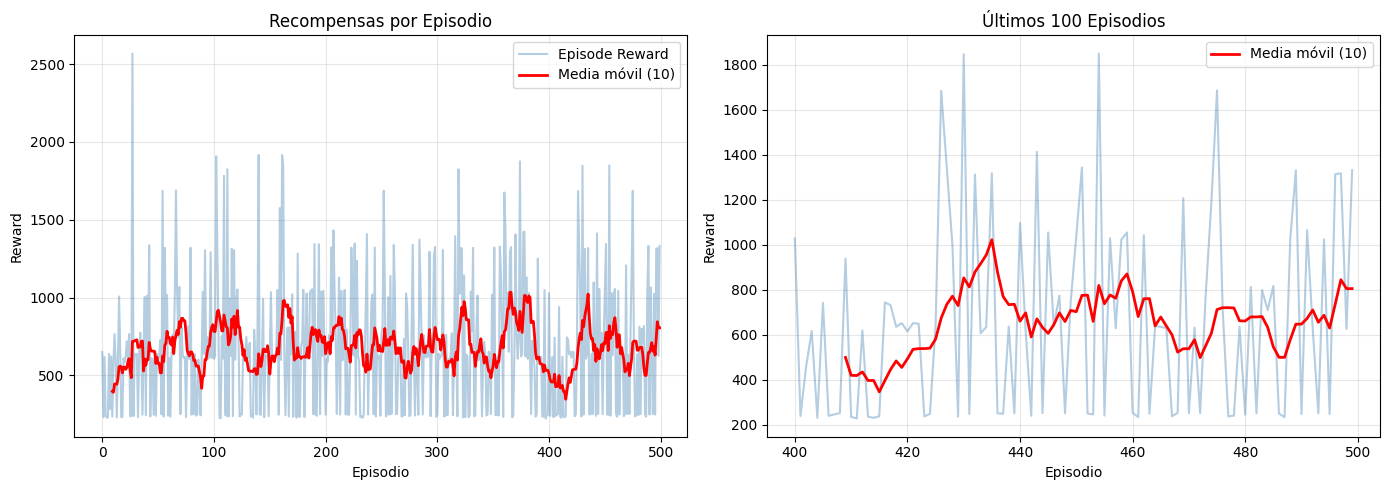


ESTADÍSTICAS FINALES
Reward promedio (últimos 10): 805.3
Reward promedio (últimos 50): 704.7
Reward máximo: 2568.0
Reward mínimo: 223.0

🔍 DIAGNÓSTICO DEL ENTRENAMIENTO

📊 Estadísticas Generales:
   Total episodios: 500
   Reward promedio: 680.69
   Reward std: 410.54
   Reward máximo: 2568.00
   Reward mínimo: 223.00

📈 Tendencia:
   Primera mitad avg: 676.91
   Segunda mitad avg: 684.48
   Mejora: +7.56 ⚠️  (Mejora lenta)

🎯 Últimos 10 episodios:
   Promedio: 805.30
   Mejor: 1332.00
   Peor: 248.00
   Std: 436.66 ⚠️  (Alta varianza - exploración activa)

📉 Análisis de estancamiento (últimos 30):
   Pendiente del promedio móvil: 7.657
   ✅ Mejorando gradualmente - seguir entrenando



In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Crear entorno con wrappers estándar
env = make_mario_env(world=1, stage=1)

# Verificar
test_state = env.reset()
print(f"Estado shape: {test_state.shape} (frames, height, width)")
print(f"Action space: {env.action_space.n} acciones")
print(f"Dtype: {np.array(test_state).dtype}, Rango: [{np.array(test_state).min()}, {np.array(test_state).max()}]")

# ========== ENTRENAMIENTO ==========
num_episodes = 500
total_rewards = train_ppo(
    env,
    model,
    num_episodes=num_episodes,
    num_epochs=4,
    batch_size=128,
    gamma=0.99,
    gae_lambda=0.95,
    learning_rate=2.5e-4,
    clip_ratio=0.2,
    entropy_coef=0.01,
    value_coef=0.5,
    device=device,
    checkpoint_freq=25,
    checkpoint_path="mario_ppo.pt",
    max_steps_per_episode=2000,
)

# ========== VISUALIZACIÓN ==========
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(total_rewards, alpha=0.4, label='Episode Reward', color='steelblue')
if len(total_rewards) >= 10:
    avg = np.convolve(total_rewards, np.ones(10)/10, mode='valid')
    plt.plot(range(9, len(total_rewards)), avg, label='Media móvil (10)', linewidth=2, color='red')
plt.xlabel('Episodio')
plt.ylabel('Reward')
plt.title('Recompensas por Episodio')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
window = min(100, len(total_rewards))
recent = total_rewards[-window:]
plt.plot(range(len(total_rewards) - window, len(total_rewards)), recent, alpha=0.4, color='steelblue')
if len(recent) >= 10:
    avg_r = np.convolve(recent, np.ones(10)/10, mode='valid')
    plt.plot(range(len(total_rewards) - window + 9, len(total_rewards)), avg_r,
             linewidth=2, color='red', label='Media móvil (10)')
plt.xlabel('Episodio')
plt.ylabel('Reward')
plt.title(f'Últimos {window} Episodios')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ========== ESTADÍSTICAS ==========
print(f"\n{'='*60}")
print(f"ESTADÍSTICAS FINALES")
print(f"{'='*60}")
print(f"Reward promedio (últimos 10): {np.mean(total_rewards[-10:]):.1f}")
if len(total_rewards) >= 50:
    print(f"Reward promedio (últimos 50): {np.mean(total_rewards[-50:]):.1f}")
print(f"Reward máximo: {max(total_rewards):.1f}")
print(f"Reward mínimo: {min(total_rewards):.1f}")
print(f"{'='*60}")

diagnostico_training(total_rewards)

## Inicio del Entrenamiento

A continuación entrenaremos el modelo PPO con la configuración estándar:

**Arquitectura:**
- CNN Actor-Critic (Nature DQN backbone + Actor/Critic heads)
- Input: 4 frames en escala de grises de 84×84
- Inicialización ortogonal para mejor estabilidad

**Parámetros:**
- **num_episodes=500**: Episodios de entrenamiento
- **num_epochs=4**: Reutilizar datos 4 veces por episodio
- **batch_size=128**: Tamaño de mini-batch
- **learning_rate=2.5e-4**: Tasa de aprendizaje estándar para PPO
- **clip_ratio=0.2**: PPO clipping
- **entropy_coef=0.01**: Incentivo de exploración
- **gamma=0.99, lambda=0.95**: Descuento y GAE

**Expectativas:**
- Primeros ~50 episodios: exploración, rewards bajos
- Episodios 50-200: aprende a avanzar hacia la derecha
- Episodios 200+: debería mejorar progresivamente, pasando obstáculos

In [12]:
"""
=== INFERENCIA: USAR EL MODELO ENTRENADO ===

Jugamos episodios usando la política aprendida con acción determinista (greedy).
"""

def play_episode(env, model, device="cpu", max_steps=2000):
    """
    Juega un episodio completo usando la política aprendida.
    Usa acción greedy (argmax) en vez de sampling para evaluar.
    """
    model.eval()
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    max_x = 40
    
    while not done and steps < max_steps:
        state_np = np.array(state, dtype=np.float32).copy()
        state_tensor = torch.tensor(state_np / 255.0, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action_logits, _ = model(state_tensor)
            action = action_logits.argmax(dim=-1)
        
        state, reward, done, info = env.step(action.item())
        total_reward += reward
        max_x = max(max_x, info.get('x_pos', 0))
        steps += 1
    
    model.train()
    return total_reward, steps, max_x

# ===== EVALUACIÓN =====
# Cargar mejor modelo si existe
best_path = "mario_ppo_best.pt"
try:
    model, _ = load_checkpoint(model, best_path, device)
    print(f"Cargado mejor modelo desde {best_path}")
except (FileNotFoundError, RuntimeError):
    print("Usando modelo actual (no se encontró best checkpoint)")

print("Evaluando modelo entrenado (5 episodios)...\n")

eval_env = make_mario_env(world=1, stage=1)
test_rewards = []
test_x_positions = []

for i in range(5):
    reward, steps, max_x = play_episode(eval_env, model, device=device)
    test_rewards.append(reward)
    test_x_positions.append(max_x)
    print(f"  Episodio {i+1}: Reward = {reward:7.1f} | Steps = {steps:4d} | Max X = {max_x:.0f}")

print(f"\n{'='*50}")
print(f"Reward promedio:  {np.mean(test_rewards):.1f} ± {np.std(test_rewards):.1f}")
print(f"Reward máximo:    {max(test_rewards):.1f}")
print(f"X position avg:   {np.mean(test_x_positions):.0f}")
print(f"X position max:   {max(test_x_positions):.0f}")
print(f"{'='*50}")
eval_env.close()

Cargado mejor modelo desde mario_ppo_best.pt
Evaluando modelo entrenado (5 episodios)...



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-712356de3a7b>:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted 

  Episodio 1: Reward =   231.0 | Steps =   40 | Max X = 296
  Episodio 2: Reward =   231.0 | Steps =   40 | Max X = 296
  Episodio 3: Reward =   231.0 | Steps =   40 | Max X = 296
  Episodio 4: Reward =   231.0 | Steps =   40 | Max X = 296
  Episodio 5: Reward =   231.0 | Steps =   40 | Max X = 296

Reward promedio:  231.0 ± 0.0
Reward máximo:    231.0
X position avg:   296
X position max:   296


## Entrenamiento con Stable Baselines3 (Entornos Paralelos)

La implementación manual anterior es útil para entender el algoritmo PPO en detalle, pero tiene una limitación fundamental: **usa un solo entorno**. El PPO estándar está diseñado para recolectar experiencias de **múltiples entornos en paralelo**, lo que:

1. **Reduce la varianza** de los gradientes: en vez de actualizar con datos de 1 episodio ruidoso, se promedian experiencias de N entornos simultáneos.
2. **Genera rollouts de tamaño fijo** (ej. 512 steps × 8 envs = 4096 steps por update) en lugar de rollouts de longitud variable por episodio.
3. **Mejora la eficiencia muestral**: más datos diversos por actualización.

Usaremos **Stable Baselines3** (SB3), la librería de referencia para RL, que implementa PPO con todas estas optimizaciones. Internamente, SB3 usa la misma arquitectura `CnnPolicy` (Nature DQN backbone) que implementamos manualmente.

In [ ]:
%pip install stable-baselines3

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import os

In [ ]:
# ========== CALLBACK PARA LOGGING ==========
class MarioCallback(BaseCallback):
    """
    Callback personalizado para registrar métricas durante el entrenamiento.
    SB3 maneja el training loop internamente, así que usamos callbacks
    para monitorear progreso y guardar checkpoints.
    """
    def __init__(self, check_freq=10000, save_path="mario_sb3.pt", verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.episode_rewards = []
        self.episode_x_positions = []
        self.best_mean_reward = -float('inf')

    def _on_step(self) -> bool:
        # Recolectar métricas de episodios completados
        if self.locals.get("infos"):
            for info in self.locals["infos"]:
                if "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
                if "x_pos" in info:
                    self.episode_x_positions.append(info["x_pos"])

        # Checkpoint periódico
        if self.n_calls % self.check_freq == 0 and len(self.episode_rewards) >= 10:
            mean_reward = np.mean(self.episode_rewards[-10:])
            if self.verbose:
                print(f"  Step {self.n_calls:>7d} | "
                      f"Episodes: {len(self.episode_rewards):>4d} | "
                      f"Avg10 Reward: {mean_reward:>7.1f} | "
                      f"Best Avg10: {self.best_mean_reward:>7.1f}")
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                self.model.save(self.save_path.replace(".pt", "_best"))
                if self.verbose:
                    print(f"  → Nuevo mejor modelo guardado (avg10={mean_reward:.1f})")
        return True

# ========== CREAR ENTORNOS VECTORIZADOS ==========
n_envs = 8  # 8 entornos simultáneos

def make_env_fn(world=1, stage=1):
    """Factory function para crear entornos."""
    def _init():
        return make_mario_env(world, stage)
    return _init

# DummyVecEnv ejecuta los entornos secuencialmente en el mismo proceso.
# SubprocVecEnv (multiprocessing) no es compatible con gym_super_mario_bros
# porque el emulador NES no soporta pickle/fork correctamente.
# DummyVecEnv es más lento pero funciona de forma confiable.
# VecMonitor registra métricas automáticamente (episode reward, length, etc.)
vec_env = VecMonitor(DummyVecEnv([make_env_fn() for _ in range(n_envs)]))

print(f"✅ {n_envs} entornos paralelos creados")
print(f"   Observation space: {vec_env.observation_space.shape}")
print(f"   Action space: {vec_env.action_space.n} acciones")

# ========== CONFIGURAR Y ENTRENAR PPO ==========
sb3_callback = MarioCallback(check_freq=10000, save_path="mario_sb3.pt")

sb3_model = PPO(
    "CnnPolicy",                # Misma arquitectura Nature DQN que usamos manualmente
    vec_env,
    n_steps=512,                # Steps por env antes de cada update (512 × 8 = 4096 total)
    batch_size=256,             # Mini-batch size para las épocas de actualización
    n_epochs=4,                 # 4 pasadas sobre los datos por update
    learning_rate=2.5e-4,       # Mismo LR que nuestra implementación
    clip_range=0.2,             # Mismo clip ratio
    ent_coef=0.01,              # Mismo coeficiente de entropía
    vf_coef=0.5,                # Mismo peso del value loss
    gamma=0.99,                 # Descuento
    gae_lambda=0.95,            # GAE lambda
    max_grad_norm=0.5,          # Gradient clipping
    verbose=0,                  # Silenciar output por defecto (usamos callback)
    device=device,
)

print(f"\n🎮 Iniciando entrenamiento SB3 PPO ({n_envs} envs paralelos)")
print(f"   Total timesteps: 2,000,000")
print(f"   Steps por update: {512 * n_envs} ({512} × {n_envs} envs)")
print(f"   Device: {device}\n")

sb3_model.learn(
    total_timesteps=2_000_000,
    callback=sb3_callback,
    progress_bar=True,
)

# Guardar modelo final
sb3_model.save("mario_sb3_final")
vec_env.close()
print(f"\n✅ Entrenamiento SB3 completado. Modelo guardado en mario_sb3_final.zip")

In [ ]:
# ========== EVALUACIÓN Y COMPARACIÓN SB3 ==========

# Cargar el mejor modelo SB3
best_sb3_path = "mario_sb3_best"
if os.path.exists(best_sb3_path + ".zip"):
    sb3_eval_model = PPO.load(best_sb3_path, device=device)
    print(f"Cargado mejor modelo SB3 desde {best_sb3_path}.zip")
else:
    sb3_eval_model = PPO.load("mario_sb3_final", device=device)
    print("Usando modelo final SB3")

# Evaluar en 10 episodios
eval_env = make_mario_env(world=1, stage=1)
sb3_rewards = []
sb3_positions = []

print("\nEvaluando modelo SB3 (10 episodios, greedy)...\n")
for i in range(10):
    obs = eval_env.reset()
    done = False
    total_reward = 0
    max_x = 40
    steps = 0

    while not done and steps < 4000:
        # SB3 usa deterministic=True para evaluación greedy
        action, _ = sb3_eval_model.predict(np.array(obs), deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        total_reward += reward
        max_x = max(max_x, info.get('x_pos', 0))
        steps += 1

    sb3_rewards.append(total_reward)
    sb3_positions.append(max_x)
    print(f"  Ep {i+1:2d}: Reward = {total_reward:7.1f} | Steps = {steps:4d} | Max X = {max_x:.0f}")

eval_env.close()

print(f"\n{'='*60}")
print(f"RESULTADOS SB3 ({n_envs} envs paralelos, 2M steps)")
print(f"{'='*60}")
print(f"Reward promedio:  {np.mean(sb3_rewards):.1f} ± {np.std(sb3_rewards):.1f}")
print(f"Reward máximo:    {max(sb3_rewards):.1f}")
print(f"X position avg:   {np.mean(sb3_positions):.0f}")
print(f"X position max:   {max(sb3_positions):.0f}")
print(f"{'='*60}")

# ========== GRÁFICO COMPARATIVO ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Curva de entrenamiento SB3
if sb3_callback.episode_rewards:
    rewards_sb3 = sb3_callback.episode_rewards
    axes[0].plot(rewards_sb3, alpha=0.3, color='steelblue', label='Episode Reward')
    if len(rewards_sb3) >= 50:
        avg = np.convolve(rewards_sb3, np.ones(50)/50, mode='valid')
        axes[0].plot(range(49, len(rewards_sb3)), avg,
                     label='Media móvil (50)', linewidth=2, color='red')
    axes[0].set_xlabel('Episodio')
    axes[0].set_ylabel('Reward')
    axes[0].set_title('SB3 PPO - Curva de Entrenamiento')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Comparación de evaluación
labels = ['PPO Manual\n(1 env, 500 eps)', 'SB3 PPO\n(8 envs, 2M steps)']
means = [np.mean(test_rewards), np.mean(sb3_rewards)]
stds = [np.std(test_rewards), np.std(sb3_rewards)]
colors = ['#ff7f0e', '#2ca02c']

bars = axes[1].bar(labels, means, yerr=stds, capsize=5, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Reward Promedio (eval)')
axes[1].set_title('Comparación: PPO Manual vs SB3')
axes[1].grid(axis='y', alpha=0.3)

# Anotar valores
for bar, mean, std in zip(bars, means, stds):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 20,
                 f'{mean:.0f} ± {std:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Comparación y Conclusiones

| Aspecto | PPO Manual (1 env) | SB3 PPO (8 envs) |
|---------|-------------------|-------------------|
| **Entornos** | 1 secuencial | 8 paralelos (SubprocVecEnv) |
| **Rollout** | Por episodio (variable) | Fijo: 512 steps × 8 envs = 4096 |
| **Varianza** | Alta (1 trayectoria por update) | Baja (8 trayectorias promediadas) |
| **Arquitectura** | PPOActorCritic (manual) | CnnPolicy (Nature DQN, equivalente) |
| **Hiperparámetros** | Idénticos (LR, clip, entropy, etc.) | Idénticos |

### ¿Por qué SB3 debería rendir mejor?

La diferencia clave no está en la arquitectura ni en los hiperparámetros (son los mismos), sino en **cómo se recolectan las experiencias**:

- **PPO Manual**: Cada update usa datos de ~100-300 steps de un solo episodio. Si Mario murió rápido en ese episodio, el gradiente será muy ruidoso.
- **SB3**: Cada update usa 4096 steps recolectados de 8 entornos independientes. Esto promedia experiencias buenas y malas, dando gradientes más estables y representativos.

Esto es la misma razón por la cual en deep learning se usan mini-batches grandes en vez de SGD puro: **reducir la varianza del gradiente permite dar pasos más confiables hacia el óptimo**.